In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def filter_string(var):
    var = var.replace(" ", "_")
    var = var.lower()
    return var

def sql_to_dataframe(db_tup):
    return pd.DataFrame(data=db_tup[1], columns=db_tup[0])

def create_national_table(df, year):
    with sqlite3.connect("safe_to_delete.db") as conn:
        df.to_sql(f"national_data_{year}", con = conn, if_exists= "replace", index= False)

def create_state_table(df, year):
    with sqlite3.connect("safe_to_delete.db") as conn:
        df.to_sql(f"arizona_state_data_{year}", con = conn, if_exists= "replace", index= False)

def run_query(q):
    with sqlite3.connect("safe_to_delete.db") as conn:# create connection
        cur = conn.cursor() # create cursor object

        cur.execute(q) # create execution

        results = cur.fetchall()
        colnames = [n[0] for n in cur.description]

    return (colnames, results)

def run_commit_query(q):
    with sqlite3.connect("safe_to_delete.db") as conn:# create connection
        cur = conn.cursor() # create cursor object
        cur.execute(q) # create execution
        conn.commit()

def clean_df(df):
    def clean_column(var):
        col = df[var]
        col = col.astype(str)
        col = col.str.replace("$", "")
        col = col.str.replace("(", "")
        col = col.str.replace(")", "")
        col = col.str.replace(",", "")
        return col

    df.columns = [filter_string(word) for word in df.columns] # replaces spaces with underscores and makes every letter lowercase
    df = df.loc[:, ['occupation_title_(click_on_the_occupation_title_to_view_its_profile)', 'employment', 'mean_hourly_wage', 'annual_mean_wage', ]] # constrain the df to these columns
    df.columns = ['occupation_title', 'employment', 'mean_hourly_wage', 'annual_mean_wage', ]
    df = df.drop(df.index[0]) # remove the first row

    df = df.reset_index(drop=True)

    df["mean_hourly_wage"] = clean_column("mean_hourly_wage").astype(float)
    df["annual_mean_wage"] = clean_column("annual_mean_wage").astype(float)
    df["employment"] = clean_column("employment").astype(float)

    return df

def make_plot_simple_trend_line(df, x, y, title, xlabel, ylabel, x_inch, y_inch):
    fig = plt.figure(figsize=(x_inch, y_inch))
    fig.patch.set_facecolor("#D5E8F3")

    colors = ["#ff42a0", "#0000a5"] * (len(x) // 2)
    if len(x) % 2:
        colors.append("#ff42a0")

    plt.scatter(x, y, color = colors)
    plt.title(title)
    plt.xlabel(xlabel, fontsize=8)
    plt.ylabel(ylabel, fontsize=8)
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.yticks(np.linspace(min(y), max(y), 12))

    plt.grid(axis="y", color="gray", linewidth=0.5)
    plt.grid(axis="x", color="gray", linewidth=0.5)
    plt.gca().set_facecolor('#E6F1F8')

    for color, label in zip(colors, plt.gca().get_xticklabels()):
        label.set_color(color)

    x_trend = df["2023_employment"]
    y_trend = df["2023_annual_mean_wage"]

    # Calculate the regression line using statsmodels.OLS
    x_trend = sm.add_constant(x_trend)  # Add a constant to represent the y-intercept
    model = sm.OLS(y_trend, x_trend)  # Create a model
    results = model.fit()  # Fit the model to the data

    # Get slope and intercept of regression line
    intercept, slope = results.params

    # Plot regression line
    x_range = np.linspace(0, len(x), len(x))  # Create array of x values to fit to the plot correctly
    plt.plot(x_range, intercept + slope * x_range, 'r', label='fitted line')  # Use 'x_range' instead of 'x_trend' to limit the line

def make_plot_simple(x, y, title, xlabel, ylabel, x_inch, y_inch):
    fig = plt.figure(figsize=(x_inch, y_inch))
    fig.patch.set_facecolor("#D5E8F3")

    colors = ["#ff42a0", "#0000a5"] * (len(x) // 2)
    if len(x) % 2:
        colors.append("red")

    plt.scatter(x, y, color = colors)
    plt.title(title)
    plt.xlabel(xlabel, fontsize=8)
    plt.ylabel(ylabel, fontsize=8)
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.yticks(np.linspace(min(y), max(y), 12))

    plt.grid(axis="y", color="gray", linewidth=0.5)
    plt.grid(axis="x", color="gray", linewidth=0.5)
    plt.gca().set_facecolor('#E6F1F8')

    for color, label in zip(colors, plt.gca().get_xticklabels()):
        label.set_color(color)
        
    #plt.subplots_adjust(bottom=0.5)

def make_plot_complex(x, y1, y2, y3, y4, y5, title, xlabel, ylabel, x_inch, y_inch):
    y_min = [y1.min(), y2.min(), y3.min(), y4.min(), y5.min()]
    y_max = [y1.max(), y2.max(), y3.max(), y4.max(), y5.max()]
    y_min = min(y_min)
    y_max = max(y_max)

    fig = plt.figure(figsize=(x_inch,y_inch))
    fig.patch.set_facecolor("#D5E8F3")

    colors = ["red", "blue", "green", "orange", "black"] 
    labels = ['y1', 'y2', 'y3', 'y4', 'y5']

    # Plot each series
    for y, color, label in zip([y1, y2, y3, y4, y5], colors, labels):
        plt.scatter(x, y, color=color, label=label)

    plt.title(title)
    plt.xlabel(xlabel, fontsize=8)
    plt.ylabel(ylabel, fontsize=8)
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.yticks(np.linspace(y_min, y_max, 12))

    plt.grid(axis="y", color="gray", linewidth=0.5)
    plt.grid(axis="x", color="gray", linewidth=0.5)
    plt.gca().set_facecolor('#E6F1F8')

    # Create a color list for x-axis labels
    label_colors = ["black" if i % 2 == 0 else "grey" for i in range(len(x))]

    for color, label in zip(label_colors, plt.gca().get_xticklabels()):
        label.set_color(color)

    # Add a legend
    plt.legend(["2023", "2022", "2021", "2020", "2019"])

def combine_national_state_df(df_one, df_two):
    combined_df = pd.DataFrame()
    combined_df["occupation_title"] = df_one["occupation_title"]
    combined_df["national_employment"] = df_one["total_employment"]
    combined_df["arizona_state_employment"] = df_two["employment"]
    combined_df = combined_df.dropna()
    #combined_df.loc[8, "occupation_title"] = "Health and Nursing Assistants"
    return combined_df

def create_clean_national_state_dfs():
    global national_2023_df, national_2022_df, national_2021_df, national_2020_df, national_2019_df
    global arizona_2023_df, arizona_2022_df, arizona_2021_df, arizona_2020_df, arizona_2019_df
    # create and clean national and state dataframes
    national_2023_df = clean_df(national_2023_df)
    arizona_2023_df = clean_df(arizona_2023_df)

    national_2022_df = clean_df(national_2022_df)
    arizona_2022_df = clean_df(arizona_2022_df)

    national_2021_df = clean_df(national_2021_df)
    arizona_2021_df = clean_df(arizona_2021_df)

    national_2020_df = clean_df(national_2020_df)
    arizona_2020_df = clean_df(arizona_2020_df)

    national_2019_df = clean_df(national_2019_df)
    arizona_2019_df = clean_df(arizona_2019_df)

def create_master_db_tables():
    global national_2023_df, national_2022_df, national_2021_df, national_2020_df, national_2019_df
    global arizona_2023_df, arizona_2022_df, arizona_2021_df, arizona_2020_df, arizona_2019_df
    # create national and state tables within an sqlite database
    create_national_table(national_2023_df, "2023")
    create_state_table(arizona_2023_df, "2023")

    create_national_table(national_2022_df, "2022")
    create_state_table(arizona_2022_df, "2022")

    create_national_table(national_2021_df, "2021")
    create_state_table(arizona_2021_df, "2021")

    create_national_table(national_2020_df, "2020")
    create_state_table(arizona_2020_df, "2020")

    create_national_table(national_2019_df, "2019")
    create_state_table(arizona_2019_df, "2019")

def remove_dups(limit_num):
    global national_2023_df, national_2022_df, national_2021_df, national_2020_df, national_2019_df
    global arizona_2023_df, arizona_2022_df, arizona_2021_df, arizona_2020_df, arizona_2019_df
    national_2023_df = sql_to_dataframe(run_query(f"SELECT * FROM national_data_2023 WHERE mean_hourly_wage > 10 ORDER BY employment DESC LIMIT {limit_num};"))
    national_2023_df = national_2023_df.drop_duplicates(subset="occupation_title", keep="first")
    arizona_2023_df = sql_to_dataframe(run_query(f"SELECT * FROM arizona_state_data_2023 WHERE mean_hourly_wage > 10 ORDER BY employment DESC LIMIT {limit_num};"))
    arizona_2023_df = arizona_2023_df.drop_duplicates(subset="occupation_title", keep="first")

    national_2022_df = sql_to_dataframe(run_query(f"SELECT * FROM national_data_2022 WHERE mean_hourly_wage > 10 ORDER BY employment DESC LIMIT {limit_num};"))
    national_2022_df = national_2022_df.drop_duplicates(subset="occupation_title", keep="first")
    arizona_2022_df = sql_to_dataframe(run_query(f"SELECT * FROM arizona_state_data_2022 WHERE mean_hourly_wage > 10 ORDER BY employment DESC LIMIT {limit_num};"))
    arizona_2022_df = arizona_2022_df.drop_duplicates(subset="occupation_title", keep="first")

    national_2021_df = sql_to_dataframe(run_query(f"SELECT * FROM national_data_2021 WHERE mean_hourly_wage > 10 ORDER BY employment DESC LIMIT {limit_num};"))
    national_2021_df = national_2021_df.drop_duplicates(subset="occupation_title", keep="first")
    arizona_2021_df = sql_to_dataframe(run_query(f"SELECT * FROM arizona_state_data_2021 WHERE mean_hourly_wage > 10 ORDER BY employment DESC LIMIT {limit_num};"))
    arizona_2021_df = arizona_2021_df.drop_duplicates(subset="occupation_title", keep="first")

    national_2020_df = sql_to_dataframe(run_query(f"SELECT * FROM national_data_2020 WHERE mean_hourly_wage > 10 ORDER BY employment DESC LIMIT {limit_num};"))
    national_2020_df = national_2020_df.drop_duplicates(subset="occupation_title", keep="first")
    arizona_2020_df = sql_to_dataframe(run_query(f"SELECT * FROM arizona_state_data_2020 WHERE mean_hourly_wage > 10 ORDER BY employment DESC LIMIT {limit_num};"))
    arizona_2020_df = arizona_2020_df.drop_duplicates(subset="occupation_title", keep="first")

    national_2019_df = sql_to_dataframe(run_query(f"SELECT * FROM national_data_2019 WHERE mean_hourly_wage > 10 ORDER BY employment DESC LIMIT {limit_num};"))
    national_2019_df = national_2019_df.drop_duplicates(subset="occupation_title", keep="first")
    arizona_2019_df = sql_to_dataframe(run_query(f"SELECT * FROM arizona_state_data_2019 WHERE mean_hourly_wage > 10 ORDER BY employment DESC LIMIT {limit_num};"))
    arizona_2019_df = arizona_2019_df.drop_duplicates(subset="occupation_title", keep="first")

def remove_occupations():
    # remove "Occupations" from the tables in the database
    tables = [f"national_data_{str(n)}" for n in range(2019,2024)]
    tables.extend([f"arizona_state_data_{str(n)}" for n in range(2019,2024)])

    for t in tables:
        q = f"DELETE FROM {t} WHERE occupation_title LIKE '%Occupations%'"
        run_commit_query(q)

def create_tables():
    global national_2023_df, national_2022_df, national_2021_df, national_2020_df, national_2019_df
    global arizona_2023_df, arizona_2022_df, arizona_2021_df, arizona_2020_df, arizona_2019_df
    national_2023_df = pd.read_html("may_2023_national_occupational_employment_and_wage_estimates.html")[0]
    national_2022_df = pd.read_html("may_2022_national_occupational_employment_and_wage_estimates.html")[0]
    national_2021_df = pd.read_html("may_2021_national_occupational_employment_and_wage_estimates.html")[0]
    national_2020_df = pd.read_html("may_2020_national_occupational_employment_and_wage_estimates.html")[0]
    national_2019_df = pd.read_html("may_2019_national_occupational_employment_and_wage_estimates.html")[0]

    arizona_2023_df = pd.read_html("arizona_may_2023_oews_state_occupational_employment_and_wage_estimates.html")[0]
    arizona_2022_df = pd.read_html("arizona_may_2022_oews_state_occupational_employment_and_wage_estimates.html")[0]
    arizona_2021_df = pd.read_html("arizona_may_2021_oews_state_occupational_employment_and_wage_estimates.html")[0]
    arizona_2020_df = pd.read_html("arizona_may_2020_oews_state_occupational_employment_and_wage_estimates.html")[0]
    arizona_2019_df = pd.read_html("arizona_may_2019_oes_state_occupational_employment_and_wage_estimates.html")[0]

def create_master_df():
    global master_df
    global national_2023_df, national_2022_df, national_2021_df, national_2020_df, national_2019_df
    
    # Start with 2023 data
    master_df = national_2023_df.copy()
    master_df.columns = ["occupation_title", "2023_employment", "2023_mean_hourly_wage", "2023_annual_mean_wage"]
    
    # List of dataframes for other years
    other_years_dfs = [national_2022_df, national_2021_df, national_2020_df, national_2019_df]
    year = 2022

    for df in other_years_dfs:
        # Rename columns
        df.columns = ["occupation_title", f"{year}_employment", f"{year}_mean_hourly_wage", f"{year}_annual_mean_wage"]
        
        # Merge data
        master_df = pd.merge(master_df, df, on="occupation_title", how="outer")

        year -= 1

    # Remove duplicates
    master_df = master_df.drop_duplicates(subset="occupation_title", keep="first")


def create_arizona_state_master_df():
    global arizona_state_master_df
    global arizona_2023_df, arizona_2022_df, arizona_2021_df, arizona_2020_df, arizona_2019_df

    # Start with 2023 data
    arizona_state_master_df = arizona_2023_df.copy()
    arizona_state_master_df.columns = ["occupation_title", "2023_employment", "2023_mean_hourly_wage", "2023_annual_mean_wage"]

    # List of dataframes for other years
    other_years_dfs = [arizona_2022_df, arizona_2021_df, arizona_2020_df, arizona_2019_df]
    year = 2022

    for df in other_years_dfs:
        # Rename columns
        df.columns = ["occupation_title", f"{year}_employment", f"{year}_mean_hourly_wage", f"{year}_annual_mean_wage"]
        
        # Merge data
        arizona_state_master_df = pd.merge(arizona_state_master_df, df, on="occupation_title", how="outer")

        year -= 1

    # Remove duplicates
    arizona_state_master_df = arizona_state_master_df.drop_duplicates(subset="occupation_title", keep="first")

In [4]:
create_tables()

In [5]:
create_clean_national_state_dfs()

In [6]:
create_master_db_tables()

In [7]:
remove_occupations()

In [8]:
remove_dups(1000)

In [9]:
create_master_df()

In [10]:
create_arizona_state_master_df()

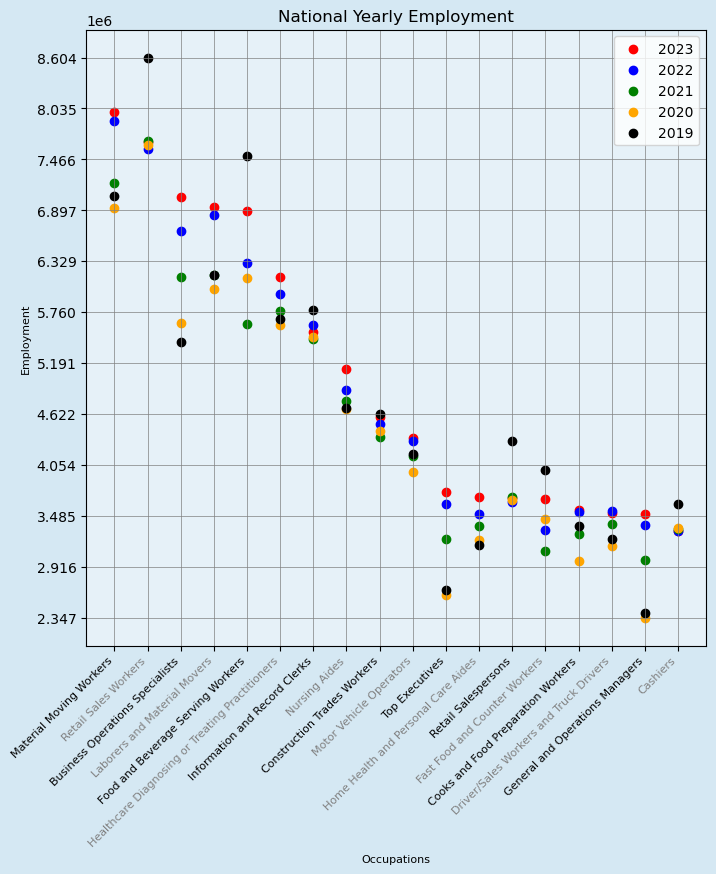

In [11]:
master_df.loc[7, "occupation_title"] = "Nursing Aides"

make_plot_complex(
    x=master_df["occupation_title"][:18],
    y1=master_df["2023_employment"][:18],
    y2=master_df["2022_employment"][:18],
    y3=master_df["2021_employment"][:18],
    y4=master_df["2020_employment"][:18],
    y5=master_df["2019_employment"][:18],
    title="national yearly employment".title(),
    xlabel="Occupations",
    ylabel="Employment",
    x_inch=8,
    y_inch=8)